# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Using TensorFlow backend.
C:\Users\Suryaa\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Suryaa\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Suryaa\anaconda3\envs\PythonGPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Suryaa\anaconda3\envs\P

# **Data segregation**

In [2]:
labels = ['Pneumonia','Normal']
img_size = 256
def datafunc(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = datafunc("C:/Users/Suryaa/Desktop/Dataset/Train")
test = datafunc("C:/Users/Suryaa/Desktop/Dataset/Test")
val = datafunc("C:/Users/Suryaa/Desktop/Dataset/Val")

C:\Users\Suryaa\anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


<AxesSubplot:ylabel='count'>

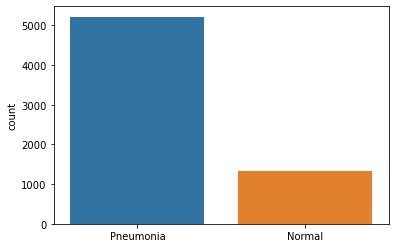

In [4]:
trainlabel = []
for img in train:
    if(img[1] == 0):
        trainlabel.append("Pneumonia")
    else:
        trainlabel.append("Normal")
sns.countplot(trainlabel)        

Text(0.5, 1.0, 'Normal')

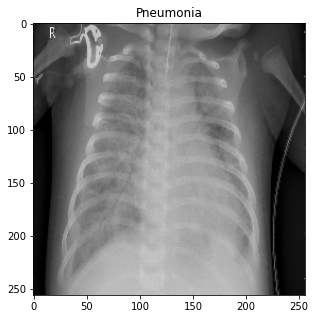

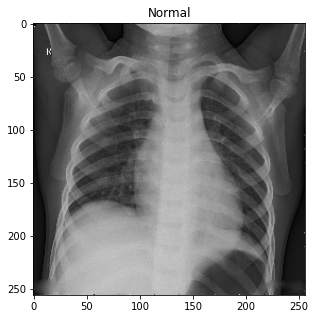

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Data processing

In [7]:
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0
x_val = np.array(x_val)/255.0

In [8]:
x_train = x_train.reshape(-1,img_size,img_size,1)
x_test = x_test.reshape(-1,img_size,img_size,1)
x_val = x_val.reshape(-1,img_size,img_size,1)

In [9]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [10]:
datagen= ImageDataGenerator(
            rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1)

In [11]:
datagen.fit(x_train)

# Building the model

In [12]:
model= Sequential()
#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(256,256,1)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(256,256,1),activation="relu"))

model.add(Dropout(0.3))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.3))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.3))

model.add(BatchNormalization())

#output layer
model.add(Dense(2,activation="softmax"))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 96)        11712     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 384)     

# Training and visualizing the results

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("alexnet.h5", monitor='val_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 40 , validation_data = datagen.flow(x_test, y_test),callbacks=[checkpoint,early])


Epoch 1/40
206/206 [==============================] - 29s 141ms/step - loss: 0.5242 - accuracy: 0.8266 - val_loss: 5.1581 - val_accuracy: 0.6256

Epoch 00001: saving model to alexnet.h5
Epoch 2/40
206/206 [==============================] - 24s 116ms/step - loss: 0.3010 - accuracy: 0.8846 - val_loss: 1.7761e-04 - val_accuracy: 0.6256

Epoch 00002: saving model to alexnet.h5
Epoch 3/40
206/206 [==============================] - 23s 112ms/step - loss: 0.2626 - accuracy: 0.8968 - val_loss: 1.2829 - val_accuracy: 0.6470

Epoch 00003: saving model to alexnet.h5
Epoch 4/40
206/206 [==============================] - 22s 106ms/step - loss: 0.2134 - accuracy: 0.9137 - val_loss: 3.3707 - val_accuracy: 0.7488

Epoch 00004: saving model to alexnet.h5
Epoch 5/40
206/206 [==============================] - 22s 107ms/step - loss: 0.2009 - accuracy: 0.9150 - val_loss: 1.4305e-06 - val_accuracy: 0.6256

Epoch 00005: saving model to alexnet.h5
Epoch 6/40
206/206 [==============================] - 22s 106

In [14]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

609/609 [==============================] - 1s 1ms/step
Loss of the model is -  0.30852621216296366
609/609 [==============================] - 1s 893us/step
Accuracy of the model is -  87.52052783966064 %


<AxesSubplot:>

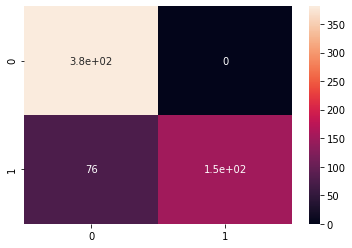

In [15]:
predictions = model.predict_classes(x_test)
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm, annot=True)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


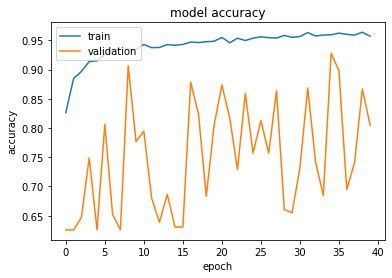

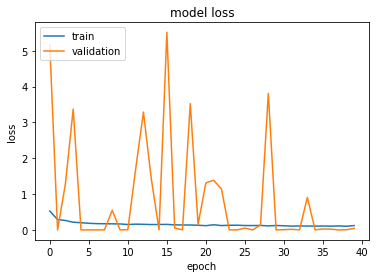

In [16]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()